
   HYBRID MLR (Research Base + Local Correction)
1. Training Base Model (Linear Regression)...
   > Base Model MAE (on Research Data): 7.13 MPa

2. Training Correction Model (Environmental Factors)...
   > Using Correction Features: ['Rainfall_Code', 'AvgTemp_0to28', 'GDD_28', 'TotalRainfall_28', 'AvgHumidity_28']

3. Validating Full System...
------------------------------
   > R² Score:   -0.0280
   > MAE:        1.8563 MPa
   > MSE:        5.0741
   > RMSE:       2.2526 MPa
   > MAPE:       5.02%
------------------------------


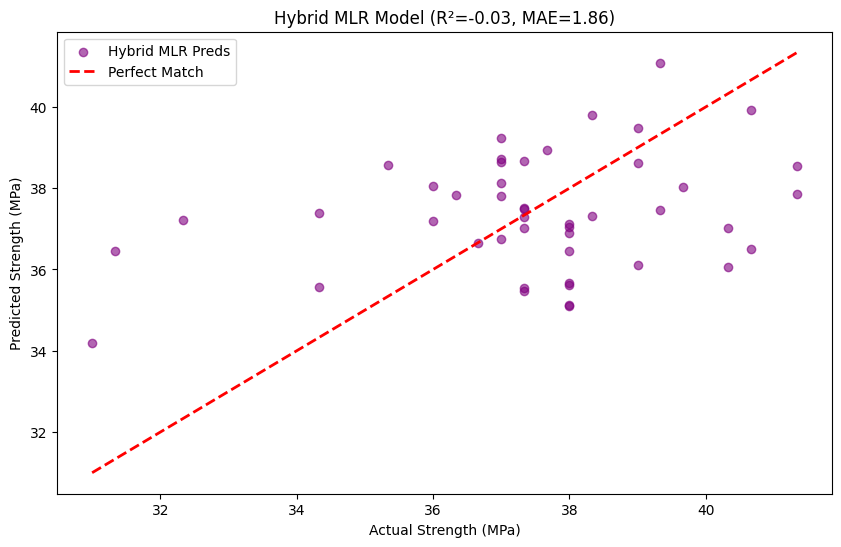

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# --- 1. LOAD DATA ---
df_kaggle = pd.read_csv("Data/zainfaisal_pakistan_concrete_data.csv")
df_local = pd.read_csv("Data/localdataset.csv")

# Clean column names
df_kaggle.columns = df_kaggle.columns.str.strip()
df_local.columns = df_local.columns.str.strip()

# --- 2. HELPER FUNCTION (Prepares Research Data) ---
def train_helper_data(df):
    # This function creates the "Base" relationship: Strength 7 -> Strength 28
    recipe_cols = ['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 
                   'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate']
    
    # Train a temporary model to impute Strength_7 for rows that only have Age=28
    df_7 = df[df['Age'] == 7].copy()
    X_helper = df_7[recipe_cols]
    y_helper = df_7['Strength']
    
    helper_model = LinearRegression()
    helper_model.fit(X_helper, y_helper)

    # Prepare 28-day data
    df_28 = df[df['Age'] == 28].copy()
    df_28['Predicted_Strength_7'] = helper_model.predict(df_28[recipe_cols])
    
    # Merge with real 7-day data where available
    df_7_grouped = df_7.groupby(recipe_cols)['Strength'].mean().reset_index()
    df_7_grouped = df_7_grouped.rename(columns={'Strength': 'Real_Strength_7'})
    
    df_augmented = pd.merge(df_28, df_7_grouped, on=recipe_cols, how='left')
    df_augmented['Strength_7'] = df_augmented['Real_Strength_7'].fillna(df_augmented['Predicted_Strength_7'])
    
    final_dataset = df_augmented[['Strength_7', 'Strength']].copy().rename(columns={'Strength': 'Strength_28'})
    return final_dataset

# --- 3. HYBRID MLR PIPELINE (Updated Features) ---
def process_mlr(df_helper, df_local):
    print("\n" + "="*40)
    print("   HYBRID MLR (Research Base + Local Correction)")
    print("="*40)

    # A. TRAIN BASE MODEL (Research Data)
    # -------------------------------------------------------
    # Learns the "Universal" physics of Strength 7 -> Strength 28
    print("1. Training Base Model (Linear Regression)...")
    X_base = df_helper[['Strength_7']]
    y_base = df_helper['Strength_28']
    
    X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_base, y_base, test_size=0.2, random_state=42)
    
    base_model = LinearRegression()
    base_model.fit(X_train_b, y_train_b)
    
    base_preds = base_model.predict(X_test_b)
    print(f"   > Base Model MAE (on Research Data): {mean_absolute_error(y_test_b, base_preds):.2f} MPa")

    # B. TRAIN CORRECTION MODEL (Local Data)
    # -------------------------------------------------------
    # Learns how Local Weather deviates from the Universal Curve
    print("\n2. Training Correction Model (Environmental Factors)...")
    
    # 1. Predict what the "Universal" model thinks the strength should be
    df_local['Base_Pred_Lab'] = base_model.predict(df_local[['Strength_7']])
    
    # 2. Calculate Residual (Difference between Reality and Universal Prediction)
    df_local['Residual'] = df_local['Strength_28'] - df_local['Base_Pred_Lab']
    
    # 3. Define Correction Features (The LATEST features you requested)
    # Note: We do NOT include Strength_7 here, as it's already in the Base Model.
    correction_features = [
        'Rainfall_Code',       # Rain on casting day
        'AvgTemp_0to28',       # Avg temp during curing
        'GDD_28',              # Growing Degree Days
        'TotalRainfall_28',    # Accumulated Rain
        'AvgHumidity_28'       # Average Humidity
    ]
    
    # Safety check to ensure columns exist
    available_features = [c for c in correction_features if c in df_local.columns]
    print(f"   > Using Correction Features: {available_features}")
    
    X_corr = df_local[available_features]
    y_corr = df_local['Residual']
    
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_corr, y_corr, test_size=0.2, random_state=42)
    
    # 4. Train Correction Model
    correction_model = LinearRegression()
    correction_model.fit(X_train_c, y_train_c)
    
    # C. FINAL VALIDATION
    # -------------------------------------------------------
    print("\n3. Validating Full System...")
    
    # Step 1: Base Prediction (Strength 7 -> Strength 28)
    test_inputs_base = df_local.loc[X_test_c.index, ['Strength_7']]
    pred_base_part = base_model.predict(test_inputs_base)
    
    # Step 2: Correction Prediction (Weather -> Residual)
    test_inputs_corr = X_test_c
    pred_corr_part = correction_model.predict(test_inputs_corr)
    
    # Step 3: Combine
    final_predictions = pred_base_part + pred_corr_part
    actual_values = df_local.loc[X_test_c.index, 'Strength_28']
    
    # --- CALCULATE METRICS ---
    final_mae = mean_absolute_error(actual_values, final_predictions)
    final_mse = mean_squared_error(actual_values, final_predictions)
    final_rmse = np.sqrt(final_mse)
    final_r2 = r2_score(actual_values, final_predictions)
    final_mape = mean_absolute_percentage_error(actual_values, final_predictions)
    
    print("-" * 30)
    print(f"   > R² Score:   {final_r2:.4f}")
    print(f"   > MAE:        {final_mae:.4f} MPa")
    print(f"   > MSE:        {final_mse:.4f}")
    print(f"   > RMSE:       {final_rmse:.4f} MPa")
    print(f"   > MAPE:       {final_mape:.2%}")
    print("-" * 30)
    
    # Visualization
    plt.figure(figsize=(10, 6))
    plt.scatter(actual_values, final_predictions, color='purple', alpha=0.6, label='Hybrid MLR Preds')
    min_val = min(min(actual_values), min(final_predictions))
    max_val = max(max(actual_values), max(final_predictions))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Match')
    plt.xlabel("Actual Strength (MPa)")
    plt.ylabel("Predicted Strength (MPa)")
    plt.title(f"Hybrid MLR Model (R²={final_r2:.2f}, MAE={final_mae:.2f})")
    plt.legend()
    plt.show()
    
    return base_model, correction_model

# --- 5. EXECUTE ---
df_helper = train_helper_data(df_kaggle)
base_model_mlr, correction_model_mlr = process_mlr(df_helper, df_local)